# Static Simulations for Estimating the Testing Capacity Required to Safely Re-open Cornell
The goal of this notebook is to provide an initial answer the following questions:

* Assuming individual pcr testing, what would be the capacity of tests required per capita (student), and the testing frequency, necessary to limit the transmission rate to close to 1 (say 1.1 or 1.2)? Since these parameters are not independent, if you could try to optimize these with some assumptions about prevalence and false negatives.

* The same thing for group testing, but optimizing group sizes and determining test capacity and frequency.

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src")
    
from population import Population
from group_testing import HouseholdGroupTest
from static_simulation import StaticSimulation
from frequency import frequency



In [20]:
doubling_time = 3.0
alpha = 2 ** (1/doubling_time)

# ignore inter-household correlation among cornell students
cornell_household_dist=[1]
SAR = 0.374 # secondary attack rate is not relevant if household sizes are all 1

beta = 1

FNR = 0.3
FPR = 0.0

# https://www.cornell.edu/about/facts.cfm
cornellpop = 24027

initial_prevalences = [0.01, 0.001, 0.0001]

reopen_pcts = [0.25,0.5,0.75,1]

group_sizes = [1,50, 100, 200]

## Simulate Resource Usage Across a number of Parameters


In [8]:
static_sim_results = {}
for prevalence in initial_prevalences:
    for reopen_pct in reopen_pcts:
        for group_size in group_sizes:
            n_students = int(reopen_pct * cornellpop)
            pop = Population(n_households=n_students, # Should be big relative to the largest group size
                          household_size_dist=cornell_household_dist,
                          target_prevalence=prevalence,
                          disease_length=0,
                          time_until_symptomatic=0,
                          non_quarantine_alpha=alpha,
                          daily_secondary_attack_rate=SAR,
                          fatality_pct=0,
                          daily_outside_infection_pct=0,
                          outside_symptomatic_prob=0,
                          initial_quarantine=0,
                          initial_prevalence=prevalence)
            test = HouseholdGroupTest(group_size,1,FNR,FPR)
            QFNR, QFPR, tests_per_person, quarantines_per_person = StaticSimulation(pop,test).sim(nreps=100)
            static_sim_results[(prevalence, reopen_pct, group_size)] = {
                'QFNR': QFNR, 'QFPR': QFPR, 'tests_per_person':tests_per_person, 
                'total_tests': tests_per_person * n_students, 'quarantines_per_person': quarantines_per_person,
                'total_quarantines': quarantines_per_person * n_students,
                'test_frequency_alpha': frequency(QFNR, alpha, beta),
                'test_frequency_alpha^1.25': frequency(QFNR, alpha**1.25, beta),
                'test_frequency_alpha^1.5':frequency(QFNR,alpha**1.5,beta)
            }
            print("Done static sims for prevalence {} and pct {} and group size {}".format(prevalence, reopen_pct, group_size))


Done static sims for prevalence 0.01 and pct 0.25 and group size 1
Done static sims for prevalence 0.01 and pct 0.25 and group size 50
Done static sims for prevalence 0.01 and pct 0.25 and group size 100
Done static sims for prevalence 0.01 and pct 0.25 and group size 200
Done static sims for prevalence 0.01 and pct 0.5 and group size 1
Done static sims for prevalence 0.01 and pct 0.5 and group size 50
Done static sims for prevalence 0.01 and pct 0.5 and group size 100
Done static sims for prevalence 0.01 and pct 0.5 and group size 200
Done static sims for prevalence 0.01 and pct 0.75 and group size 1
Done static sims for prevalence 0.01 and pct 0.75 and group size 50
Done static sims for prevalence 0.01 and pct 0.75 and group size 100
Done static sims for prevalence 0.01 and pct 0.75 and group size 200
Done static sims for prevalence 0.01 and pct 1 and group size 1
Done static sims for prevalence 0.01 and pct 1 and group size 50
Done static sims for prevalence 0.01 and pct 1 and group

In [22]:
static_sim_results

{(0.0001, 0.25, 1): {'QFNR': 0.3516666666666666,
  'QFPR': 0.0,
  'quarantines_per_person': 0.00014652014652014652,
  'test_frequency_alpha': 4.523158505366087,
  'test_frequency_alpha^1.25': 3.6185268042928698,
  'test_frequency_alpha^1.5': 3.015439003577391,
  'tests_per_person': 1.0,
  'total_quarantines': 0.88,
  'total_tests': 6006.0},
 (0.0001, 0.25, 50): {'QFNR': 0.25666666666666665,
  'QFPR': 0.008258928716948354,
  'quarantines_per_person': 0.008426573426573427,
  'test_frequency_alpha': 5.886096449402938,
  'test_frequency_alpha^1.25': 4.708877159522351,
  'test_frequency_alpha^1.5': 3.924064299601959,
  'tests_per_person': 0.020146520146520148,
  'total_quarantines': 50.61000000000001,
  'total_tests': 121.00000000000001},
 (0.0001, 0.25, 100): {'QFNR': 0.33333333333333326,
  'QFPR': 0.015275725301567797,
  'quarantines_per_person': 0.015427905427905427,
  'test_frequency_alpha': 4.75488750216347,
  'test_frequency_alpha^1.25': 3.803910001730776,
  'test_frequency_alpha^1.5'

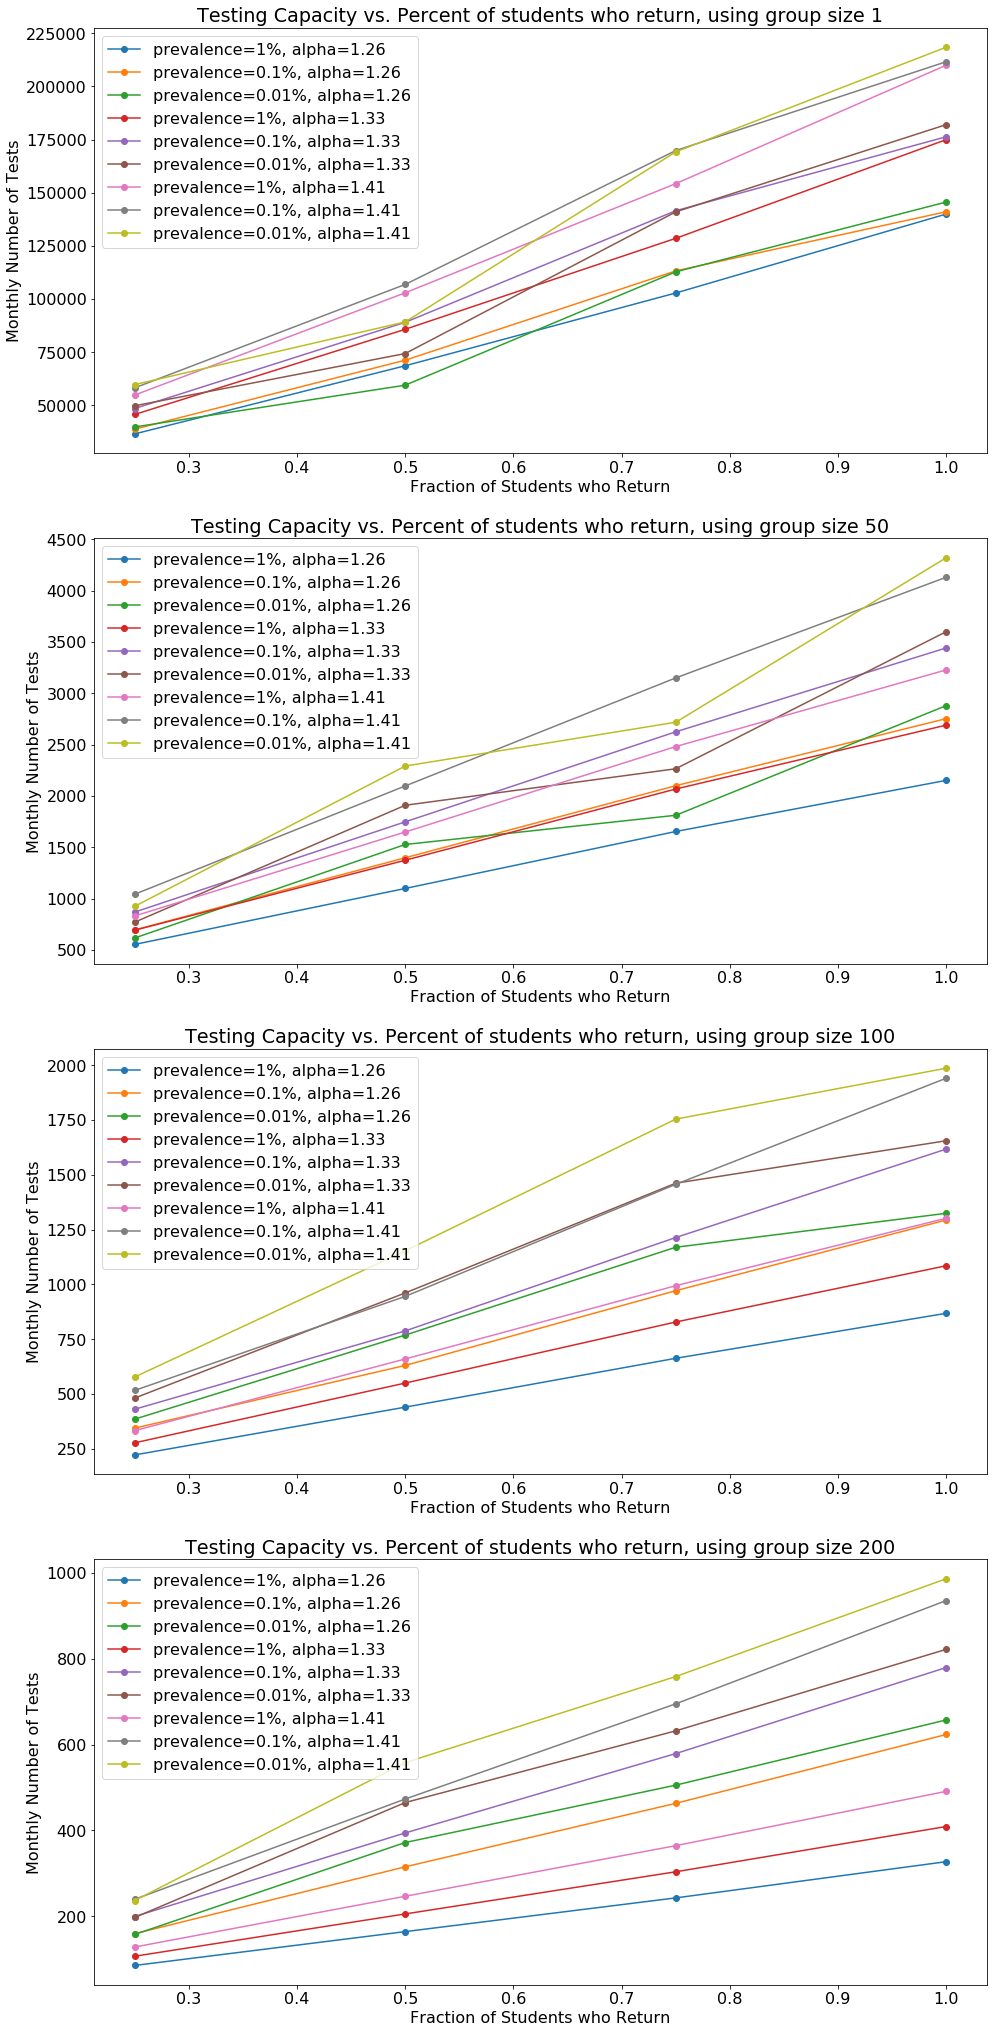

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,36))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Capacity vs. Percent of students who return, using group size {}".format(group_size))
    for alpha, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]
                test_magnitude = static_sim_results[(prevalence, reopen_pct, group_size)]['total_tests']

                monthly_tests.append(test_magnitude * 30 / test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Monthly Number of Tests")

    plt.legend(loc='best')

        
    
